In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
data.sample(10)

,Quarter,Sales
30,Q3_93,3629.000000
41,Q2_96,5253.000000
32,Q1_94,3352.000000
6,Q3_87,2014.362999
37,Q2_95,4936.000000
3,Q4_86,2154.962997
13,Q2_89,2331.164993
5,Q2_87,2104.411995
27,Q4_92,3243.859993
29,Q2_93,3899.000000


### Data Preprocessing

In [3]:
data.shape

(42, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [5]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [6]:
data.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [7]:
# lets separate Quarter column as Year and Quarter
data[['Quarters','Year']] = data['Quarter'].str.split(pat = '_', expand = True)
data.head(5)

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [8]:
data['Quarters'].unique()

array(['Q1', 'Q2', 'Q3', 'Q4'], dtype=object)

In [9]:
# Getting dummy variables for Quarters
data_final = pd.get_dummies(data = data,columns=['Quarters'])
data_final.head(5)

,Quarter,Sales,Year,Quarters_Q1,Quarters_Q2,Quarters_Q3,Quarters_Q4
0,Q1_86,1734.827000,86,1,0,0,0
1,Q2_86,2244.960999,86,0,1,0,0
2,Q3_86,2533.804993,86,0,0,1,0
3,Q4_86,2154.962997,86,0,0,0,1
4,Q1_87,1547.818996,87,1,0,0,0


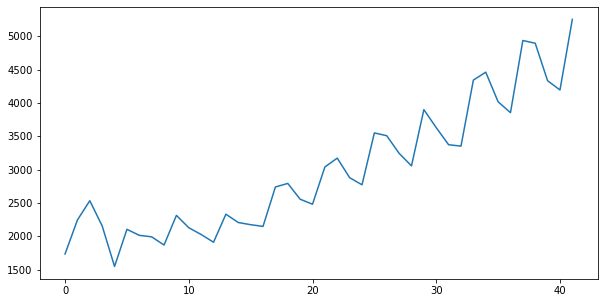

In [10]:
# Lineplot for Sales of CocaCola
plt.figure(figsize=(10,5))
plt.plot(data_final['Sales'])

<AxesSubplot:ylabel='Density'>

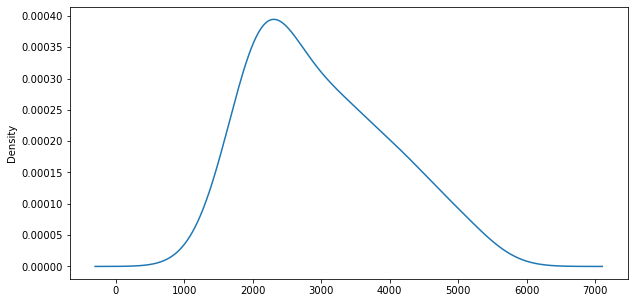

In [11]:
# density plot
data['Sales'].plot(kind = 'density',figsize = (10,5))

<AxesSubplot:xlabel='Year', ylabel='Sales'>

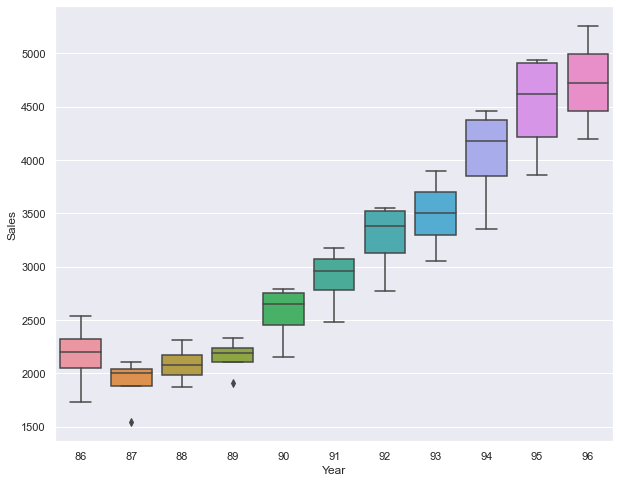

In [12]:
# Boxplot
sns.set(rc={'figure.figsize':(10,8)})
sns.boxplot(x=data_final['Year'],y=data_final['Sales'],data = data_final)

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

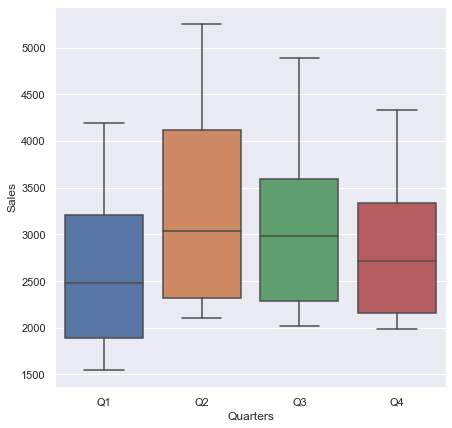

In [13]:
#boxplot of Quarters Vs. Sales
sns.set(rc={'figure.figsize':(7,7)})
sns.boxplot(x="Quarters",y="Sales",data=data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

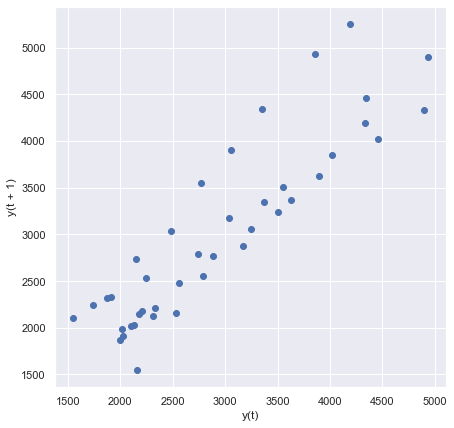

In [14]:
# lag plot for sales
from pandas.plotting import lag_plot
lag_plot(data_final['Sales'])

##### It has been positively correlated.

<AxesSubplot:xlabel='Quarters', ylabel='Year'>

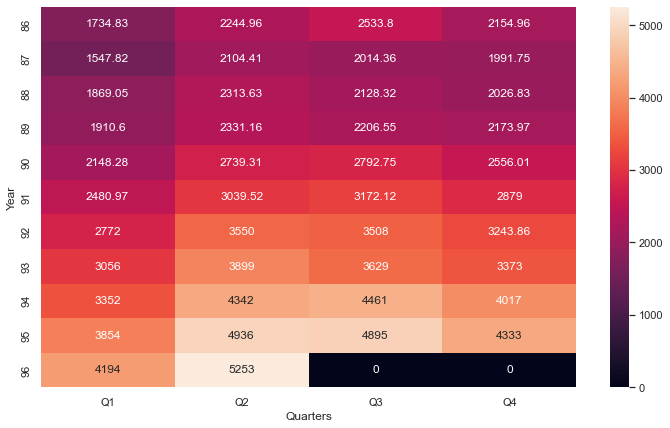

In [15]:
# heatmap to find how the sales are for each and quarter
plt.figure(figsize=(12, 7))
heatmap_yr_quar = pd.pivot_table(data=data,values="Sales",index="Year",columns="Quarters",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_yr_quar,annot=True,fmt="g")

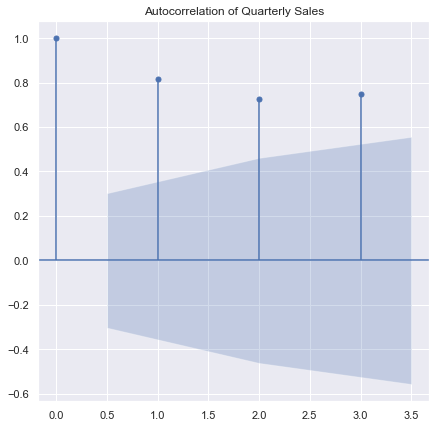

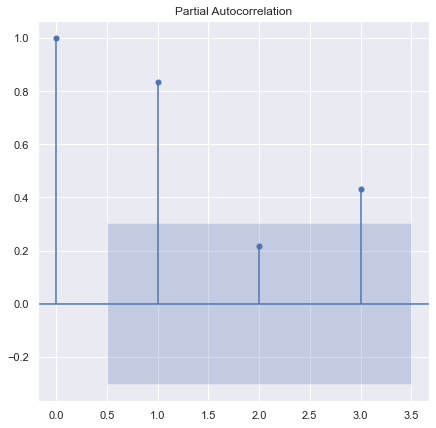

In [16]:
# Creating Auto Correlation plots for Quarterly sales
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Sales,lags=3,title='Autocorrelation of Quarterly Sales')
tsa_plots.plot_pacf(data.Sales,lags=3)
plt.show()

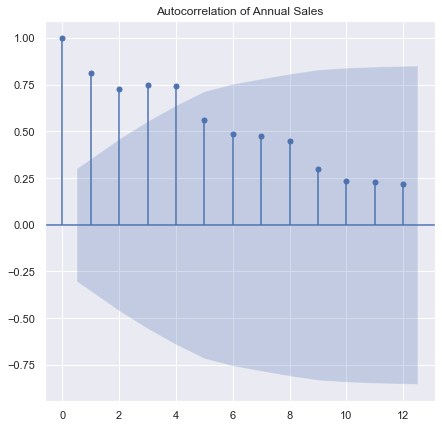

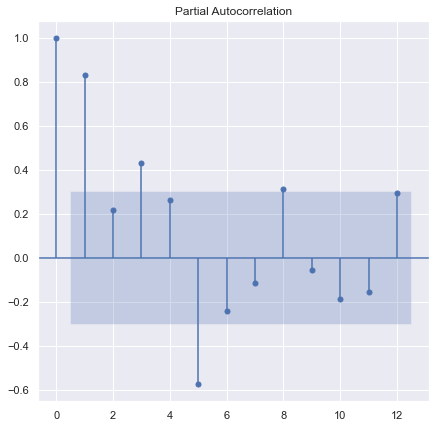

In [17]:
# Creating Auto Correlation plots for Annual sales
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Sales,lags=12,title='Autocorrelation of Annual Sales')
tsa_plots.plot_pacf(data.Sales,lags=12)
plt.show()

### Data Driven Methods

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose

### Splitting data

In [19]:
train_data = data_final.head(32)
test_data = data_final.tail(10)

#### Moving Average (MA) Method

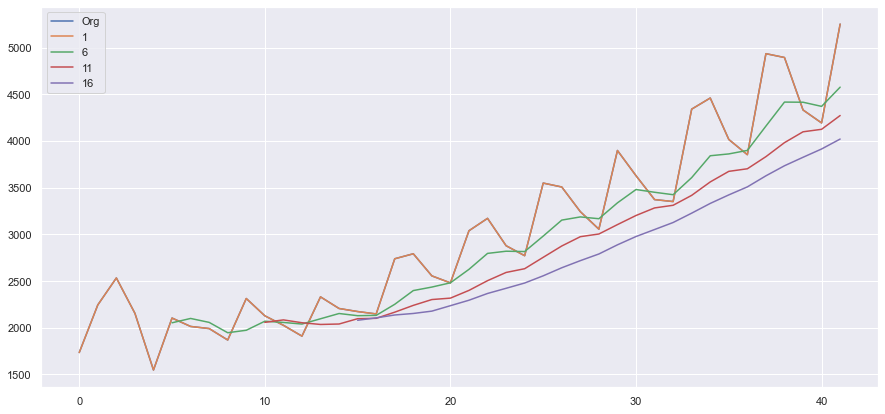

In [20]:
plt.figure(figsize=(15,7))
data_final.Sales.plot(label='Org')
for i in range(1,20,5):
    data_final['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend()

### Time series decomposition plot

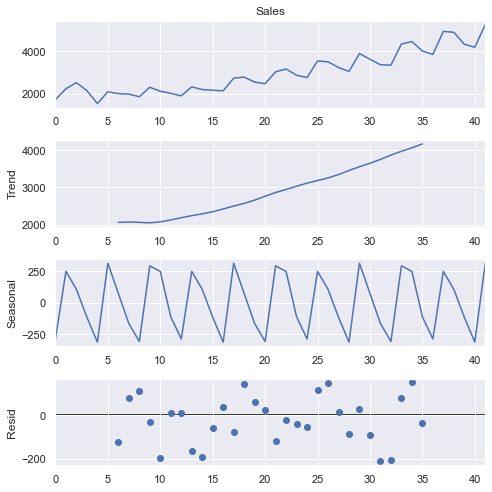

In [21]:
decompose_ts = seasonal_decompose(data_final.Sales,period=12)
decompose_ts.plot()
plt.show()

### Evaluation Metric MAPE

In [22]:
def MAPE(pred,actual):
    error = np.abs((actual-pred)/actual)*100
    return error.mean()

### Simple Exponential Method

In [23]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
mape_ses_model=MAPE(pred_ses,test_data.Sales)
mape_ses_model

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


22.724051812293908

### Holt method / Double Exp Method

In [24]:
holt_model = Holt(train_data["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_holt = holt_model.predict(start = test_data.index[0],end = test_data.index[-1])
mape_holt_model=MAPE(pred_holt,test_data.Sales) 
mape_holt_model

C:\Users\HP\AppData\Local\Temp/ipykernel_3332/4100490855.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  holt_model = Holt(train_data["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)


16.720651186614823

### Holts winter exponential smoothing with additive seasonality and additive trend

In [25]:
hwe_model_add_add = ExponentialSmoothing(train_data["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend and seasonal to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test_data.index[0],end = test_data.index[-1])
mape_hwe_model_add_add=MAPE(pred_hwe_add_add,test_data.Sales) 
mape_hwe_model_add_add

10.577658977019563

#### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [26]:
hwe_model_mul_add = ExponentialSmoothing(train_data["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test_data.index[0],end = test_data.index[-1])
mape_hwe_model_mul_add=MAPE(pred_hwe_mul_add,test_data.Sales) 
mape_hwe_model_mul_add

8.034230885582044

### Final Model by combining train and test

In [44]:
hwe_model_mul_add = ExponentialSmoothing(data_final["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [45]:
#Forecasting for next 10 time periods
hwe_model_mul_add.forecast(10)

42    4952.314037
43    4770.788582
44    4800.316951
45    5675.454848
46    5711.783474
47    5288.541844
48    5164.349293
49    6121.011980
50    6006.187360
51    5539.652544
dtype: float64

### Model based Forecasting Methods

In [27]:
def RMSE(pred,actual):
    error = np.sqrt(np.mean((np.array(actual)-np.array(pred))**2))
    return error.mean()

In [28]:
# Data preprocessing for models
data_final["t"] = np.arange(1,43)
data_final["t_squared"] = data_final["t"]*data_final["t"]

data_final["log_sales"] = np.log(data_final["Sales"])

data_final.head()

,Quarter,Sales,Year,Quarters_Q1,Quarters_Q2,Quarters_Q3,Quarters_Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,87,1,0,0,0,5,25,7.344602


In [29]:
train_data = data_final.head(32)
test_data = data_final.tail(10)

In [30]:
train_data.head(5)

,Quarter,Sales,Year,Quarters_Q1,Quarters_Q2,Quarters_Q3,Quarters_Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,87,1,0,0,0,5,25,7.344602


#### Linear Model

In [31]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear_model=RMSE(pred_linear,test_data['Sales'])
rmse_linear_model

752.9233932767121

##### Exponential

In [32]:
Exp = smf.ols('log_sales~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp=RMSE(pred_Exp,test_data['Sales'])
rmse_Exp

4387.940544839098

##### Quadratic Model

In [33]:
Quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(pd.DataFrame(test_data[["t","t_squared"]])))
rmse_Quad=RMSE(pred_Quad,test_data['Sales'])
rmse_Quad

457.7357355407437

In [34]:
#Additive seasonality 

add_sea = smf.ols('Sales~Quarters_Q1+Quarters_Q2+Quarters_Q3',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Quarters_Q1', 'Quarters_Q2', 'Quarters_Q3']]))
rmse_add_sea = RMSE(pred_add_sea,test_data['Sales'] )
rmse_add_sea
                 

1850.4665461858358

In [35]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales ~ t+t_squared+Quarters_Q1+Quarters_Q2+Quarters_Q3',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Quarters_Q1', 'Quarters_Q2', 'Quarters_Q3','t','t_squared']]))
rmse_add_sea_quad = RMSE(pred_add_sea_quad,test_data['Sales'] )
rmse_add_sea_quad

277.351077112877

In [36]:
# Multiplicative Seasonality model
Mul_sea = smf.ols('log_sales~Quarters_Q1+Quarters_Q2+Quarters_Q3',data=train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mul_sea = RMSE(test_data['Sales'], np.exp(pred_Mult_sea))
rmse_Mul_sea

1908.2503948361139

In [37]:
# Multiplicative Additive Seasonality model

Mul_Add_sea = smf.ols('log_sales~t+Quarters_Q1+Quarters_Q2+Quarters_Q3',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mul_Add_sea = RMSE(test_data['Sales'], np.exp(pred_Mult_add_sea))
rmse_Mul_Add_sea

448.8678182691915

In [39]:
#Compare the results 

list_data_driven = [['Simple Exponential Method',mape_ses_model], ['Holt method',mape_holt_model],
          ['HW exp smoothing add',mape_hwe_model_add_add],['HW exp smoothing mult',mape_hwe_model_mul_add]]
          
score = pd.DataFrame(list_data_driven, columns =['Data Driven Model', 'RMSE_Value']) 
score

,Data Driven Model,RMSE_Value
0,Simple Exponential Method,22.724052
1,Holt method,16.720651
2,HW exp smoothing add,10.577659
3,HW exp smoothing mult,8.034231


In [40]:
list_model_driven = [['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp],['Quad model',rmse_Quad],
          ['add seasonality',rmse_add_sea],['Quad add seasonality',rmse_add_sea_quad],
          ['Mult Seasonality',rmse_Mul_sea],['Mult add seasonality',rmse_Mul_Add_sea]]
score = pd.DataFrame(list_model_driven, columns =['Model Driven Model', 'RMSE_Value']) 
score

,Model Driven Model,RMSE_Value
0,Linear Mode,752.923393
1,Exp model,4387.940545
2,Quad model,457.735736
3,add seasonality,1850.466546
4,Quad add seasonality,277.351077
5,Mult Seasonality,1908.250395
6,Mult add seasonality,448.867818


### Building final model with least RMSE value - Quad add seasonality Model

In [42]:
final_model = smf.ols('Sales~t+t_squared+Quarters_Q1+Quarters_Q2+Quarters_Q3',data=data_final).fit()
pred_final = pd.Series(final_model.predict(data_final[['Quarters_Q1','Quarters_Q2','Quarters_Q3','t','t_squared']]))
rmse_final_model = RMSE(data_final['Sales'], pred_final)
rmse_final_model

159.05522576522472

In [43]:
pred_df = pd.DataFrame({'Actual' : data_final.Sales, 'Predicted' : pred_final})
pred_df

,Actual,Predicted
0,1734.827000,1626.592727
1,2244.960999,2268.402339
2,2533.804993,2189.685821
3,2154.962997,1867.242917
4,1547.818996,1658.311143
5,2104.411995,2314.185178
6,2014.362999,2249.533083
7,1991.746998,1941.154603
8,1869.049999,1746.287252
9,2313.631996,2416.225709


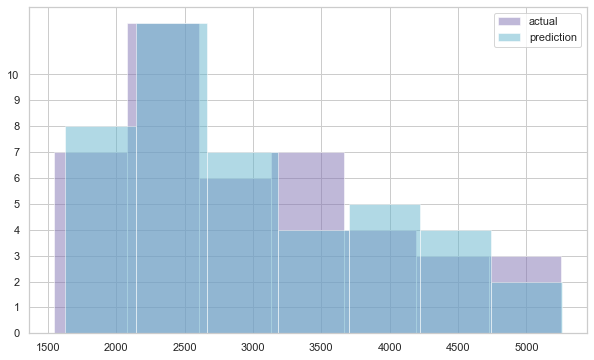

In [46]:
# Actual Vs Predicted graph

sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (10, 6) 
_, ax = plt.subplots()
ax.hist(data.Sales, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred_final, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()